Dagier Thomas
Rod Quentin
# CNN - CIFAR10 - Data Augmentation

In [10]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('\033[91m' + 'WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('\033[92m' + 'OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


## Loading the packages

In [11]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

%matplotlib inline

Define a function to plot some images from CIFAR and load the dataset.

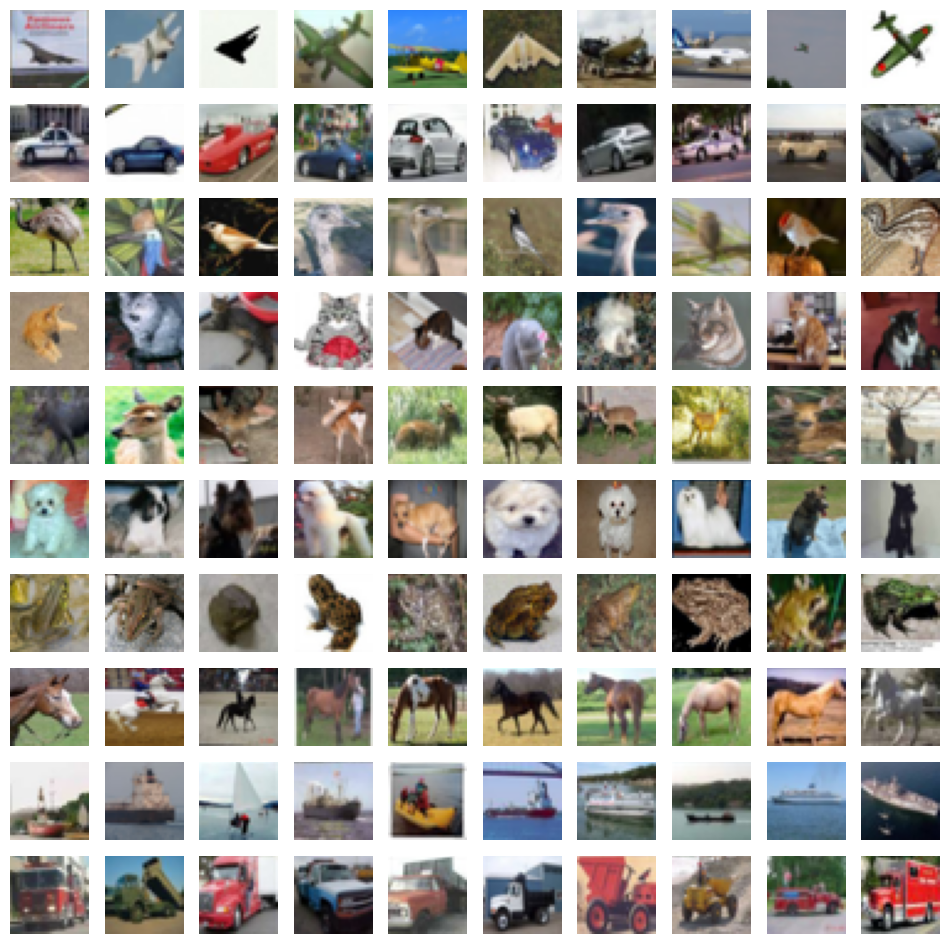

training input shape :  (50000, 32, 32, 3)
training output shape:  (50000, 1)
testing input shape  :  (10000, 32, 32, 3)
testing output shape :  (10000, 1)


In [12]:
def show_imgs(X,y):
    plt.figure(1, figsize=(12,12))
    k = 0
    for i in range(0,10):
        for j in range(0,10):
            while y[k] != i: k += 1
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k += 1
    plt.show()

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
show_imgs(X_test, y_test)
print('training input shape : ', X_train.shape)
print('training output shape: ', y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', y_test.shape)

### Preprocessing data
After loading and splitting the data, we need to preprocess them by reshaping them into the shape the network expects and scaling them so that all values are in the \[0, 1\] interval.

The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [13]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

50000 train samples
10000 test samples
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Define the network
The neural network will be a CNN. Follow the structure given in the exercise 1.

In [14]:
def cnn_arch_create_seq():
    KER_SIZE = (3,3)
    cnn = Sequential()
    cnn.add(Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1), input_shape=(X_train.shape[1:])))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1), input_shape=(X_train.shape[1:])))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Flatten())
    cnn.add(Dense(n_classes, activation='softmax'))
    return cnn

def cnn_arch_create_func(archID = 0):
    KER_SIZE = (3,3)
    visible = Input(shape=(X_train.shape[1:]))
    end = None

    if archID == 0:
        hidden1 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(visible)
        hidden2 = Activation('relu')(hidden1)
        hidden3 = MaxPooling2D(pool_size=(2,2))(hidden2)
        hidden4 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(hidden3)
        hidden5 = Activation('relu')(hidden4)
        hidden6 = MaxPooling2D(pool_size=(2,2))(hidden5)
        end = Flatten()(hidden6)

    if archID == 1:
        #First path
        hidden1 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(visible)
        hidden2 = Activation('relu')(hidden1)
        hidden3 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(hidden2)
        hidden4 = Activation('relu')(hidden3)
        hidden5 = MaxPooling2D(pool_size=(2,2))(hidden4)
        flat1 = Flatten()(hidden5)
        #Same path in parallel
        hidden1_2 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(visible)
        hidden2_2 = Activation('relu')(hidden1_2)
        hidden3_2 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(hidden2_2)
        hidden4_2 = Activation('relu')(hidden3_2)
        hidden5_2 = MaxPooling2D(pool_size=(2,2))(hidden4_2)
        flat1_2 = Flatten()(hidden5_2)
        #Concat
        end = Concatenate()([flat1, flat1_2])

    if archID == 2:
        #First path
        hidden1 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(visible)
        hidden2 = Activation('relu')(hidden1)
        flat1 = Flatten()(hidden2)
        #Second path
        hidden1_2 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(visible)
        hidden2_2 = Activation('relu')(hidden1_2)
        hidden3_2 = Conv2D(64,KER_SIZE,padding= 'same', strides=(2, 2))(hidden2_2)
        hidden4_2 = Activation('relu')(hidden3_2)
        hidden5_2 = Conv2D(128,KER_SIZE,padding= 'same', strides=(2, 2))(hidden4_2)
        hidden6_2 = Activation('relu')(hidden5_2)
        hidden7_2 = MaxPooling2D(pool_size=(2,2))(hidden6_2)
        flat1_2 = Flatten()(hidden7_2)
        #Concat
        end = Concatenate()([flat1, flat1_2])

    if archID == 3:
        hidden1 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(visible)
        hidden2 = Activation('relu')(hidden1)
        hidden3 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(hidden2)
        hidden4 = Activation('relu')(hidden3)
        hidden5 = MaxPooling2D(pool_size=(2,2))(hidden4)
        flat1 = Flatten()(hidden5)
        
        hidden6 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(hidden5)
        hidden7 = Activation('relu')(hidden6)
        hidden8 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(hidden7)
        hidden9 = Activation('relu')(hidden8)
        hidden10 = MaxPooling2D(pool_size=(2,2))(hidden9)
        flat2 = Flatten()(hidden10)

        hidden11 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(hidden10)
        hidden12 = Activation('relu')(hidden11)
        hidden13 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(hidden12)
        hidden14 = Activation('relu')(hidden13)
        hidden15 = MaxPooling2D(pool_size=(2,2))(hidden14)
        flat3 = Flatten()(hidden15)
        #Concat
        end = Concatenate()([flat1, flat2, flat3])
    if archID == 4:
        hidden1 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(visible)
        hidden2 = Activation('relu')(hidden1)
        hidden3 = Conv2D(32,KER_SIZE,padding= 'same', strides=(1, 1))(hidden2)
        hidden4 = Activation('relu')(hidden3)
        hidden5 = MaxPooling2D(pool_size=(2,2))(hidden4)
        flat1 = Flatten()(hidden5)
        
        hidden6 = Conv2D(64,KER_SIZE,padding= 'same', strides=(2, 2))(hidden5)
        hidden7 = Activation('relu')(hidden6)
        hidden8 = Conv2D(128,KER_SIZE,padding= 'same', strides=(4, 4))(hidden7)
        hidden9 = Activation('relu')(hidden8)
        hidden10 = MaxPooling2D(pool_size=(2,2))(hidden9)
        flat2 = Flatten()(hidden10)
        #Concat
        end = Concatenate()([flat1, flat2])

    dense1 = Dense(100, activation="relu")(end)
    output = Dense(n_classes, activation='softmax')(dense1)
    return Model(inputs=visible, outputs=output)


## Compile and train the network

When compiling the model, we need to specify the loss function, the optimizer and the metrics we want to track during the training. In Keras, we need to call the methods `compile()` and `fit()`. We will train through E epochs, using batches of size B, as specified in the exercise 1.

- The `categorical_crossentropy` loss is relevant for multiclass, single-label classification problem. Categorical is used because there are 10 classes to predict from. If there were 2 classes, we would have used `binary_crossentropy`.
- The `adam` optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is defining the update rule for the weights of the neurons during backpropagation gradients.

### Data Augmentation

Overfitting can be caused by having networks with too many parameters that are trained on too few samples. Through training, the model learns *by hart* and generalizes poorly.

**Data augmentation** takes the approach of generating artificially more training data from existing training samples. For images, data augmentation is performed via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will not see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ```ImageDataGenerator``` instance.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.

In [15]:
B = 128
E = 20
USE_DATA_AUGMENTATION = True
USE_SEQ_MODEL = True


cnn = cnn_arch_create_seq() if USE_SEQ_MODEL else cnn_arch_create_func(0)
cnn.summary()
plot_model(cnn, to_file='CNN_graph.png')

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5', verbose=1,
monitor='val_accuracy',save_best_only=True,
mode='auto')


if USE_DATA_AUGMENTATION :
    
     ### Define the data augmentation pipelines, one for train set, one for test set
    gen = ImageDataGenerator(rotation_range=8,
    width_shift_range=0.08,
    shear_range=0.3,
    height_shift_range=0.08,
    zoom_range=0.08)

    batches = gen.flow(X_train, Y_train, batch_size=B)
    val_batches = gen.flow(X_test, Y_test, batch_size=B)

    ############
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    log = cnn.fit(batches,
                steps_per_epoch=X_train.shape[0]//B,
                epochs=E,
                validation_data=val_batches,
                validation_steps=X_test.shape[0]//B,
                use_multiprocessing=True,
                callbacks=[checkpoint])

else:
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    log = cnn.fit(X_train, Y_train, batch_size=B, epochs=E, verbose=1, validation_data=(X_test, Y_test), callbacks=[checkpoint])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_2 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 activation_3 (Activation)   (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                    

2023-05-16 11:00:19.348813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


390/390 [==============================] - ETA: 0s - loss: 1.6589 - accuracy: 0.4098

2023-05-16 11:01:08.447259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.48568, saving model to model-001.h5
390/390 [==============================] - 58s 147ms/step - loss: 1.6589 - accuracy: 0.4098 - val_loss: 1.4500 - val_accuracy: 0.4857
Epoch 2/20
390/390 [==============================] - ETA: 0s - loss: 1.3881 - accuracy: 0.5110
Epoch 2: val_accuracy improved from 0.48568 to 0.53476, saving model to model-002.h5
390/390 [==============================] - 58s 149ms/step - loss: 1.3881 - accuracy: 0.5110 - val_loss: 1.3274 - val_accuracy: 0.5348
Epoch 3/20
390/390 [==============================] - ETA: 0s - loss: 1.2898 - accuracy: 0.5483
Epoch 3: val_accuracy improved from 0.53476 to 0.56701, saving model to model-003.h5
390/390 [==============================] - 63s 162ms/step - loss: 1.2898 - accuracy: 0.5483 - val_loss: 1.2318 - val_accuracy: 0.5670
Epoch 4/20
390/390 [==============================] - ETA: 0s - loss: 1.2267 - accuracy: 0.5707
Epoch 4: val_accuracy improved from 0.56701 to 0.57572, s

## Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss and accuracy evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

2023-05-16 11:20:43.811375: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


Test loss: 0.9245834946632385
Test accuracy: 0.6875


2023-05-16 11:20:45.757010: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


array([[776,  24,  21,   8,   5,  11,  14,  30,  49,  62],
       [ 17, 855,   2,   2,   0,   5,   6,  10,  10,  93],
       [100,   7, 432,  28,  74,  82, 142, 105,  12,  18],
       [ 33,  18,  48, 350,  51, 219, 141, 101,  16,  23],
       [ 31,   5,  45,  23, 520,  36, 130, 190,  12,   8],
       [ 20,   5,  24,  74,  33, 648,  49, 128,   5,  14],
       [  5,   6,  17,  18,  19,  19, 888,  17,   3,   8],
       [ 16,   3,  16,   7,  16,  41,  17, 862,   3,  19],
       [ 94,  71,   7,   8,   4,  13,   8,  18, 734,  43],
       [ 25,  95,   3,   3,   3,   4,  13,  30,  14, 810]])

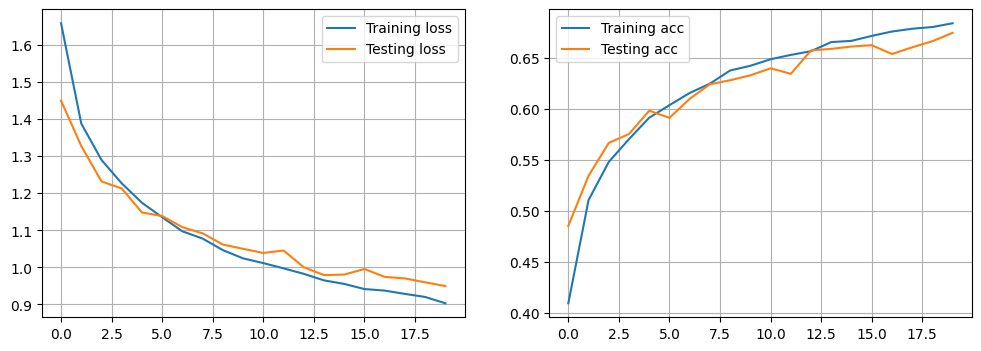

In [16]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

pred = np.argmax(cnn.predict(X_test, verbose=0),1)
confusion_matrix(y_test, pred)

### Table of results

Describe your data augmentation strategies here.

| CNN                      | Architecture description | Callback | Acc. train | Acc. test |
|--------------------------|--------------------------|----------|------------|-----------|
| Sequential               | CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | yes |  0.8312 | 0.7196 |
| Functional (0)           | CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2) | yes | 0.8264 | 0.7179 |
| Functional (1) - 2 paths | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2) | yes | 0.8787 | 0.7167 |
| Functional (2) - 2 paths | CONV(32F,same)-RELU-CONV(32F,same)-CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2) | yes | 0.9245 | 0.6875 |
| Functional (3)           | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2) | yes | 0.6767 | 0.7925 |
| Functional (4)           | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2) | yes | 0.80705 | 0.7336 |

# Visualisation of Activations

In [17]:
def CNN_activations_maps(im_in, iLayer, cnn):
    
    im_in_shape = np.array(im_in).shape
    # extracts the output of the layer
    layer_output = cnn.layers[iLayer].output

    # creates a model able to return these outputs, given an input
    activation_model = models.Model(inputs=cnn.input, outputs=layer_output)

    # we need to reshape the image as the network expect a batch of images as input
    im_in = im_in.reshape(1,im_in_shape[0],im_in_shape[1],im_in_shape[2])

    # returns the first layer activation
    layer_activation = activation_model.predict(im_in)
    nb_activations = layer_activation.shape[-1]
    
   
    ncol = 8
    nrow = nb_activations // ncol

    fig, axs = plt.subplots(
    nrow, ncol,
    gridspec_kw=dict(wspace=0.0, hspace=0.0,
                     top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                     left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1)),
    figsize=(ncol + 1, nrow + 1),
    sharey='row', sharex='col', #  optionally
    
    )
    fig.suptitle('Layer ' + str(iLayer), fontsize=16)

    for i in range(nrow):
        for j in range(ncol):
            axs[i,j].axis('off')

            axs[i,j].matshow(layer_activation[0, :, :, i*j + j], cmap='Greys')

1/1 [==============================] - 0s 35ms/step


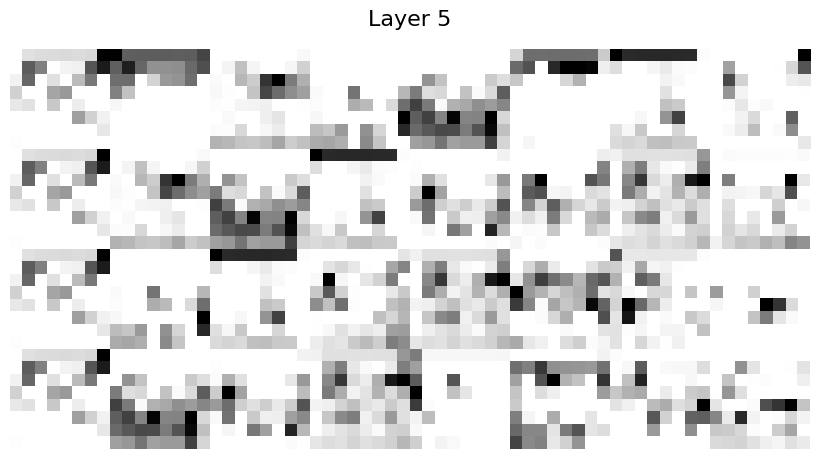

In [18]:
im_in = X_train[12]
CNN_activations_maps(im_in, 5, cnn)